## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [142]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [143]:
df = pd.read_csv('ab_data.csv')

In [144]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [145]:
# determine the size of the dataframe using shape and select the first value which corresponds to the number of rows

df.shape[0]

294478

c. The number of unique users in the dataset.

In [146]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [147]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [148]:
# using get_dummies the group column is split into control and treatment columns and stored in the original dataframe
# the 1's in control corresponds to the users who are in control group. Same for the treatment column

df[['control', 'treatment']] = pd.get_dummies(df['group'])

In [149]:
# using get_dummies the landing_page column is split into new_page and old_page columns and stored in the dataframe
# the 1's in new_page corresponds to the users who were shown the new page. Same for the old_page column

df[['new_page', 'old_page']] = pd.get_dummies(df['landing_page'])

In [150]:
# number of times the treatment and new_page don't match

sum(df.treatment == df.old_page)

3893

f. Do any of the rows have missing values?

In [151]:
sum(df.user_id.isna())

0

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [152]:
df2 = df[df.treatment == df.new_page]

In [153]:
df2.head()

,user_id,timestamp,group,landing_page,converted,control,treatment,new_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,1


In [154]:
# Double Check all of the correct rows were removed - this should be 0

df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [155]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [156]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted,control,treatment,new_page,old_page
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0,0,1,1,0


c. What is the row information for the repeat **user_id**? 

index: 2893

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [157]:
# drop the row with index 2893 since it is duplicate value

df2.drop([2893], inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [158]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [159]:
df2[df2.group=='control'].converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [160]:
df2[df2.group=='treatment'].converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [161]:
(df.landing_page=='new_page').mean()

0.5

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**No there is no evidence to prove that the new treatment page leads to higher conversion rate. Infact the opposite is true that control group has slightly higher proability of conversion compared to treatment group.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_o: p_{new} \leq p_{old}$$ 
$$H_1: p_{new} >  p_{old}$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

In [162]:
df2.head()

,user_id,timestamp,group,landing_page,converted,control,treatment,new_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,1


a. What is the **conversion rate** for $p_{new}$ under the null? 

In [163]:
p_new = round(df2.converted.mean(),4)
p_new

0.1196

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [164]:
p_old = round(df2.converted.mean(),4)
p_old

0.1196

c. What is $n_{new}$, the number of individuals in the treatment group?

In [165]:
n_new = sum(df2.group == 'treatment')
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [166]:
n_old = sum(df2.group == 'control')
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [167]:
# simulate n_new transactions from the binominal distribution with conversion rate p_new

new_page_converted = np.random.binomial(1, p_new, n_new)
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [168]:
# simulate n_old transactions from the binominal distribution with conversion rate p_old

old_page_converted = np.random.binomial(1, p_old, n_old)
old_page_converted

array([0, 0, 1, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [169]:
p_new - p_old

0.0

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [170]:
# carry out sample simulation for 10000 times the difference in mean for each iterations is stored in p_diffs

p_diffs = []

for _ in range(10000):
    new_page_convert = np.random.binomial(n_new, p_new)
    old_page_convert = np.random.binomial(n_old, p_old)
    diff = new_page_convert/n_new - old_page_convert/n_old
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [171]:
# determine the absolute difference in mean

treatment_group = df2.query('group == "treatment"')['converted'].mean()
control_group = df2.query('group == "control"')['converted'].mean()
obs_diff = treatment_group - control_group

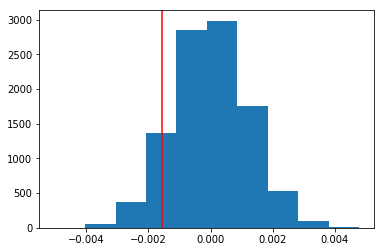

In [172]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs)
plt.axvline(obs_diff, c='red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [173]:
# determine the p_value which is given by

print('p_value =', (p_diffs > obs_diff).mean())

p_value = 0.9036


k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**First the actual mean is calculated from the ab_data.csv which is denoted by obs_diff then the difference in mean is calculated from the sample simulation which is p_diff. In the step J the proportions of p_diff greater than obs_diff is determined which is nothing but the p_value. Since the p-value is close to 1 this implies that we fail to reject the null hypothesis (conversion for new and old page is same).**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [174]:
import statsmodels.api as sm

convert_old = sum((df2.group == 'control') & (df2.converted == 1))  # no. of users in control group who converted
convert_new = sum((df2.group == 'treatment') & (df2.converted == 1)) # no. of users in treatment group who converted
n_old = sum(df2.group == 'control') # no. of users in control group
n_new = sum(df2.group == 'treatment') # no. of users in treatment group

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [175]:
# determine z_score and p_value using ztest
# by declaring the alternative as smaller we perform a one sided t-test 

z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], 
                                              [n_old, n_new], alternative='smaller')
print('z_score =', z_score) 
print('p_value =', p_value)

z_score = 1.31092419842
p_value = 0.905058312759


In [176]:
# we first find out the significance of the z_score using a cumulative distribution function

from scipy.stats import norm
norm.cdf(z_score)

0.90505831275902449

In [177]:
# considering an alpha value = 0.05 lets determine the critical z_score to have 95% confidence

print('z_score_critical =', norm.ppf(1-(0.05)))

z_score_critical = 1.64485362695


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The z-score indicates how many standard deviations above/below from the mean we are. From the previous p_value we had determined that we fail to reject the null hypothesis. When we did a similar analysis with built-in function we get a z_score and p_value of 1.31 and 0.905 respectively. For a 95% confidence the critical z_score needed was 1.644. A much lower z_score further strengths that we fail to reject the null hypothesis (conversion for old and new page is same).**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Since we will have only two outcomes (conversion or no conversion) we can use logistic regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [178]:
# create two new columns in our dataframe called intercept and ab_page

df2['intercept'] = 1
df2['ab_page'] = df2.treatment

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [179]:
df2.head()

,user_id,timestamp,group,landing_page,converted,control,treatment,new_page,old_page,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [180]:
# perform a logistic regression where 'converted' is the response 
# 'intercept' and 'ab_page' are the exploratory variables

import statsmodels.api as sm

log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-02-01 22:50 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [181]:
# for logistic regression we need to exponentiate the coefficient for ab_page
# since the exponentiated value is less than 1 we have to take the reciprocal

print(np.exp(-0.0150))
print('ab_page =', 1/np.exp(-0.0150))

0.985111939603
ab_page = 1.01511306462


**The above value indicates that the conversion rate for treatment group is 1.015 times lower than control group.**

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**In Part II the null and alternative hypothesis are:**

$H{_o}$: ${p_n}$ <= $p{_o}$<br>
$H{_1}$: $p{_n}$ > $p{_o}$

**In Part III the null and alternative are:**

$H{_o}$: ${p_n}$ = $p{_o}$<br>
$H{_1}$: $p{_n}$ ≠ $p{_o}$

**In Part II the p_value is 0.905 whereas in the Part III it is 0.189. The difference in p_value is because in Part-II we performed a one-sided t-test whereas in the Part-III it is two-sided t-test. Since the p_value is larger than the alpha = 0.05 we fail to reject the null hypothesis.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**The p_value suggests there is no significant difference in the conversion for different landing pages. Additionally, we could try to use other exploratory variables such timestamp, age and location. However, when multiple exploratory variables are used there could be a problem with multilinearity i.e the variables are corelated to each rather than only the response y.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [182]:
# read out the countries from the csv file and merge and store it in our dataframe df3

countries = pd.read_csv('countries.csv')
df3 = df2.merge(countries, on='user_id', how='left')

In [183]:
# using get_dummies funciton from pandas the countries column is split into three different columns
# in each country column 1's correspond to that user being from that particular country

df3[['CA', 'UK', 'US']] = pd.get_dummies(df3.country)

In [184]:
# drop the country column from our dataframe df3

df3.drop(['country'], axis=1, inplace=True)

In [185]:
# perform a logistic regression where the reponse(y) is given by 'converted'
# the exploratory variables are intercept, CA, UK and ab_page. Here the US is choosen as baseline

import statsmodels.api as sm

log_mod = sm.Logit(df3['converted'], df3[['intercept', 'CA', 'UK', 'ab_page']])
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-02-01 22:50 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
==================================================================

"""

In [186]:
# in logistic regression we take the exponentiated values of the coefficient

np.exp(-0.0408), np.exp(0.0099), np.exp(-0.0149)

(0.96002111497165088, 1.0099491671175422, 0.9852104557227469)

In [187]:
# for values below 1 reciprocal is taken

print('CA =', 1/np.exp(-0.0408))
print('UK =', np.exp(0.0099))
print('ab_page =', 1/np.exp(-0.0149))

CA = 1.04164375596
UK = 1.00994916712
ab_page = 1.01501155838


**Observing the coefficients we can conclude that users form Canada have 1.041 times lower conversion rates when compared to users from US. However, UK users have 1.009 times higher conversion rates compared to US. Additionally, the conversion rate for treatment group is 1.015 times lower than control group. By including more exploratory variables the p_value has slightly increased to 0.1912 however, the Pseudo R-squared is still the same.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [188]:
# the columns ab_page and CA are multiplied and stored in ab_page_CA. 
# 1's in the ab_page_CA column correspond to users from Canada who were in treatment group and 0's in control group 
# Similar case for ab_page_UK and ab_page_US

df3['ab_page_CA'] = df3['ab_page']*df3['CA']
df3['ab_page_UK'] = df3['ab_page']*df3['UK']
df3['ab_page_US'] = df3['ab_page']*df3['US']

In [189]:
# perform a logistic regression with reponse as converted
# and exploratory variables as intercept, ab_page_CA and ab_page_UK with ab_page_US as baseline

log_mod = sm.Logit(df3['converted'], df3[['intercept','ab_page_CA', 'ab_page_UK']])
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-02-01 22:50 AIC:              212779.0384
No. Observations:   290584           BIC:              212810.7773
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9963    0.0062  -322.0487  0.0000  -2.0084  -1.9841
ab_page_CA   -0.0752    0.0376    -1.9974  0.0458  -0.1489  -0.0014
ab_page_UK    0.0149    0.0173     0.8617  0.3888  -0.0190   0.0488
==================================================================

"""

In [190]:
# in logistic regression we take the exponentiated values of the coefficient

np.exp(-0.0752), np.exp(0.0149)

(0.92755795618491998, 1.0150115583846535)

In [191]:
# for exponentiated values below 1 reciprocal is taken

print('ab_page_CA =', 1/np.exp(-0.0752))
print('ab_page_UK =', np.exp(0.0149))

ab_page_CA = 1.07809974927
ab_page_UK = 1.01501155838


**From the above results we see that the conversion rates for the treatment group from Canada is 1.07 times lower than the US. However, the conversion rate for treatment group from UK is 1.015 times greater than US.**

In [192]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0